#### Librerias

In [1]:
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

#### Opciones

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)
plt.style.use("ggplot")

#### Variables

In [3]:
DATA_PATH: Path = Path("../data")

#### Cargar datos

In [4]:
df: pd.DataFrame = pd.read_parquet(path=DATA_PATH / "data.parquet.gzip", engine="fastparquet")
print(f"Filas: {df.shape[0]:,}, Columnas: {df.shape[1]:,}")
df.head()

Filas: 100,000, Columnas: 57


warranty sub_status condition deal_ids  base_price   seller_id  \
0                None        NaN       new     None        80.0  8208882349   
1  NUESTRA REPUTACION        NaN      used     None      2650.0  8141699488   
2                None        NaN      used     None        60.0  8386096505   
3                None        NaN       new     None       580.0  5377752182   
4      MI REPUTACION.        NaN      used     None        30.0  2938071313   

  listing_type_id   price buying_mode parent_item_id category_id  \
0          bronze    80.0  buy_it_now  MLA6553902747   MLA126406   
1          silver  2650.0  buy_it_now  MLA7727150374    MLA10267   
2          bronze    60.0  buy_it_now  MLA6561247998     MLA1227   
3          silver   580.0  buy_it_now           None    MLA86345   
4          bronze    30.0  buy_it_now  MLA3133256685    MLA41287   

              descriptions                     last_updated             id  \
0  MLA4695330653-912855983        2015-09-05 20:42:58+00:00  MLA4695330653   
1  MLA7160447179-930764806        2015-09-26 18:08:34+00:00  MLA7160447179   
2  MLA7367189936-916478256        2015-09-09 23:57:10+00:00  MLA7367189936   
3  MLA9191625553-932309698 2015-10-05 16:03:50.306000+00:00  MLA9191625553   
4  MLA7787961817-902981678        2015-08-28 13:37:41+00:00  MLA7787961817   

   official_store_id  accepts_mercadopago  original_price currency_id  \
0                NaN                 True             NaN         ARS   
1                NaN                 True             NaN         ARS   
2                NaN                 True             NaN         ARS   
3                NaN                 True             NaN         ARS   
4                NaN                 True             NaN         ARS   

                                           thumbnail  \
0  http://mla-s1-p.mlstatic.com/5386-MLA469533065...   
1  http://mla-s1-p.mlstatic.com/23223-MLA71604471...   
2  http://mla-s1-p.mlstatic.com/22076-MLA73671899...   
3  http://mla-s2-p.mlstatic.com/183901-MLA9191625...   
4  http://mla-s2-p.mlstatic.com/13595-MLA77879618...   

                                               title  automatic_relist  \
0  Auriculares Samsung Originales Manos Libres Ca...             False   
1  Cuchillo Daga Acero Carbón Casco Yelmo Solinge...             False   
2        Antigua Revista Billiken, N° 1826, Año 1954             False   
3  Alarma Guardtex Gx412 Seguridad Para El Automo...             False   
4                          Serenata - Jennifer Blake             False   

               date_created  \
0 2015-09-05 20:42:53+00:00   
1 2015-09-26 18:08:30+00:00   
2 2015-09-09 23:57:07+00:00   
3 2015-09-28 18:47:56+00:00   
4 2015-08-24 22:07:20+00:00   

                                    secure_thumbnail           stop_time  \
0  https://a248.e.akamai.net/mla-s1-p.mlstatic.co... 2015-11-04 20:42:53   
1  https://a248.e.akamai.net/mla-s1-p.mlstatic.co... 2015-11-25 18:08:30   
2  https://a248.e.akamai.net/mla-s1-p.mlstatic.co... 2015-11-08 23:57:07   
3  https://a248.e.akamai.net/mla-s2-p.mlstatic.co... 2015-12-04 01:13:16   
4  https://a248.e.akamai.net/mla-s2-p.mlstatic.co... 2015-10-23 22:07:20   

   status video_id  catalog_product_id  initial_quantity          start_time  \
0  active     None                 NaN                 1 2015-09-05 20:42:53   
1  active     None                 NaN                 1 2015-09-26 18:08:30   
2  active     None                 NaN                 1 2015-09-09 23:57:07   
3  active     None                 NaN                 1 2015-09-28 18:47:56   
4  active     None                 NaN                 1 2015-08-24 22:07:20   

                                           permalink  sold_quantity  \
0  http://articulo.mercadolibre.com.ar/MLA4695330...              0   
1  http://articulo.mercadolibre.com.ar/MLA7160447...              0   
2  http://articulo.mercadolibre.com.ar/MLA7367189...              0   
3  http://articulo.mercadolibr

## Analisis Univariado

In [5]:
def plot_categorical_dist(
    df: pd.DataFrame, column: str, title: str = "", xlabel: str = "Porcentaje (%)", ylabel: str = "", figsize: tuple = (4, 4)
) -> None:
    """
    Crea un gráfico de barras para una variable categórica.

    Args:
        df: DataFrame con los datos.
        column: Nombre de la columna categórica.
        title: Título del gráfico (opcional).
        xlabel: Etiqueta del eje X (opcional).
        ylabel: Etiqueta del eje Y (opcional).

    """
    ax = (
        df[column]
        .value_counts(normalize=True, dropna=False)
        .sort_values()
        .mul(100)
        .round(2)
        .plot(kind="barh", xlabel=xlabel, ylabel=ylabel or column, title=title or f"Distribución de {column}", figsize=figsize)
    )

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f%%", label_type="edge", padding=2)

    plt.tight_layout()
    plt.show()

In [6]:
def create_wordcloud(df: pd.DataFrame, column_name: str) -> None:
    """
    Crea una nube de palabras para la columna seleccionada.

    Args:
        df (pd.DataFrame): El dataframe que contiene la columna.
        column_name (str): La columna a la que se le quiere realizar la nube de palabras.
    """
    text = " ".join(df[column_name].dropna().astype(str))
    text = re.sub(r"[^\w\s]", "", text.lower())
    word_freq = Counter(text.split())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### Label (Condicion)

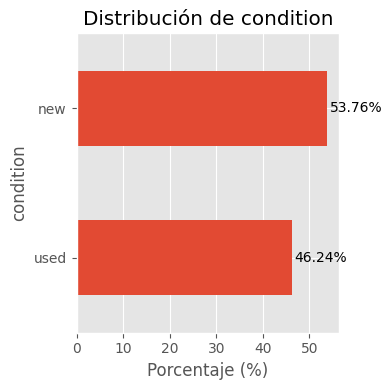

In [7]:
plot_categorical_dist(df=df, column="condition")

- Estamos frente a un problema de clasificacion ligeramente desbalanceado. La clase `Usada` representa alrededor del 46.24% de los datos, mientras que la clase `Nueva` representa alrededor del 53.76% de los datos.

#### Categoricas

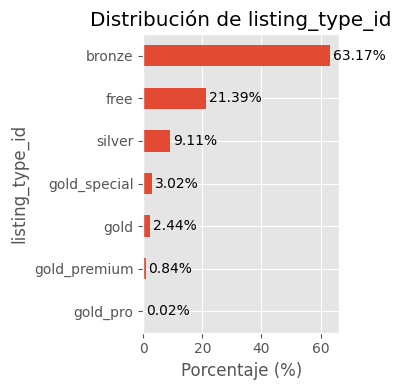

In [8]:
plot_categorical_dist(df=df, column="listing_type_id")

- Los publicaciones de tipo `Bronce` representan al 63.17% de los datos, seguido de las publicaciones gratuitas con un 21.39%. El restante se divide entre las publicacines `Silver` y `Gold`.

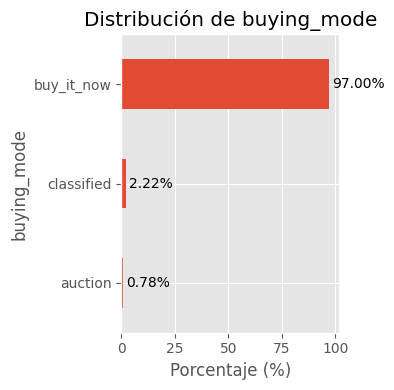

In [9]:
plot_categorical_dist(df=df, column="buying_mode")

- El 97% de los datos tiene la categoria de `Compralo Ahora`, 0.78% son de `Subasta` y el restante 2.2% pertenecen a `Clasificados`.
- No es claro a que corresponde la categoria de `Clasificados`.

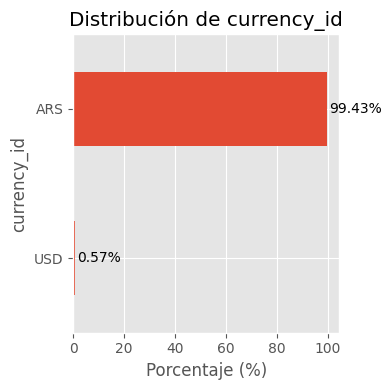

In [10]:
plot_categorical_dist(df=df, column="currency_id")

- El 99.5% de los datos esta listado en `Pesos Argentinos`, y el 0.05% restante esta listando en `Dolares`

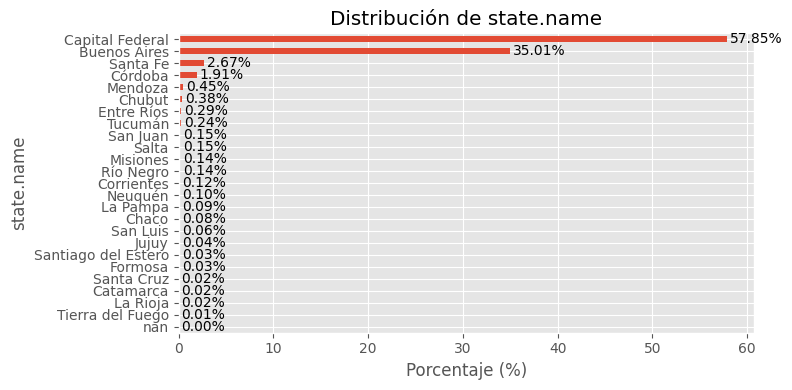

In [11]:
plot_categorical_dist(df=df, column="state.name", figsize=(8, 4))

- El 57.85% son publicaciones donde la direccion del vendedor corresponde a `CABA`. El 35.01 son publicaciones donde la direccion del vendedor corresponde a la `Provincia de Buenos Aires`. El restante se lo reparten entre las demas provincias y un pequeño numero de publicaciones con valores faltantes. 

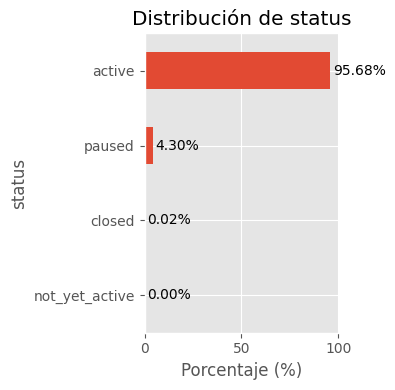

In [12]:
plot_categorical_dist(df=df, column="status")

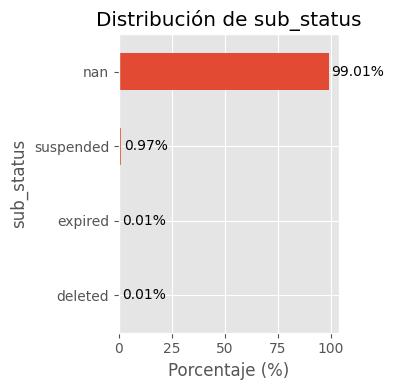

In [13]:
plot_categorical_dist(df=df, column="sub_status")

In [14]:
df[["status", "sub_status"]].value_counts(dropna=False).to_frame()

count
status         sub_status       
active         NaN         95675
paused         NaN          3338
               suspended     966
closed         expired        13
               deleted         7
not_yet_active NaN             1

#### Booleanos

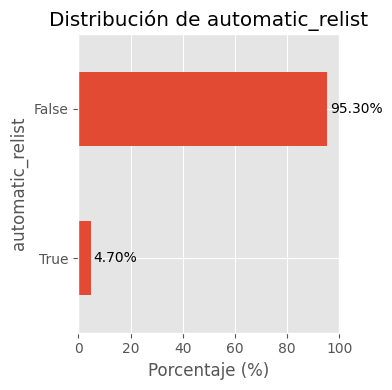

In [15]:
plot_categorical_dist(df=df, column="automatic_relist")

- Solo el 4.7% de las publicaciones tienen `automatic relist`. Sin embargo, no es claro que significa esta caracteristica.

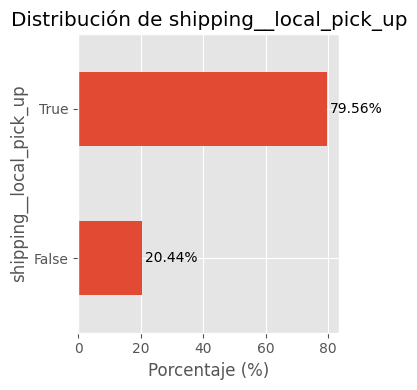

In [16]:
plot_categorical_dist(df=df, column="shipping__local_pick_up")

- El 79.56% de las publicaciones ofrecen `Recogida en tienda`

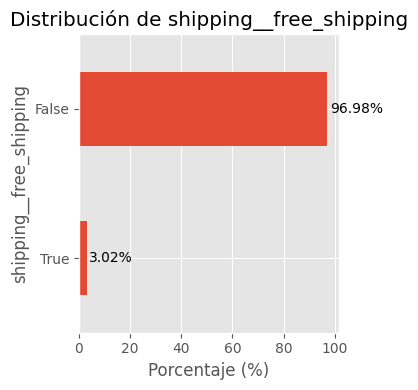

In [17]:
plot_categorical_dist(df=df, column="shipping__free_shipping")

- El 3.02% de las publicaciones ofrecen `Envio gratis`

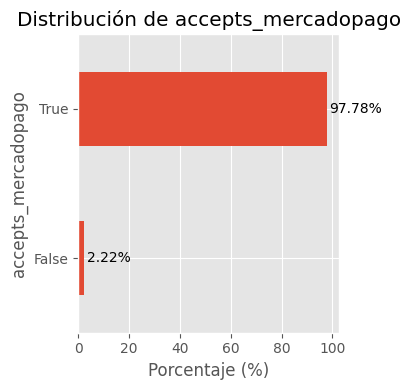

In [18]:
plot_categorical_dist(df=df, column="accepts_mercadopago")

- El 97.78% de las publicaciones aceptan `MercadoPago` como medio de pago. A continuacion se realiza el mismo analisis pero para medios de pagos diferentes a `MercadoPago`:

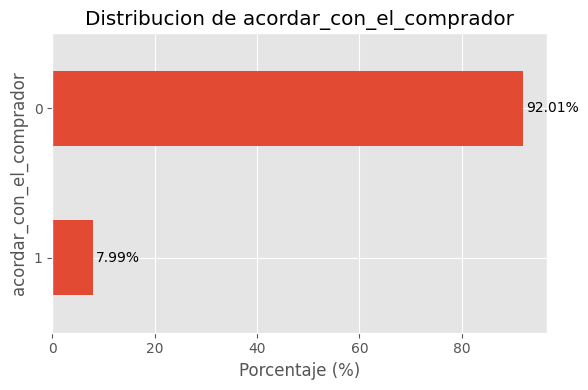

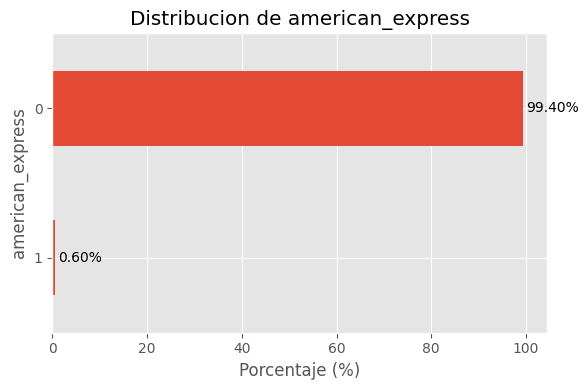

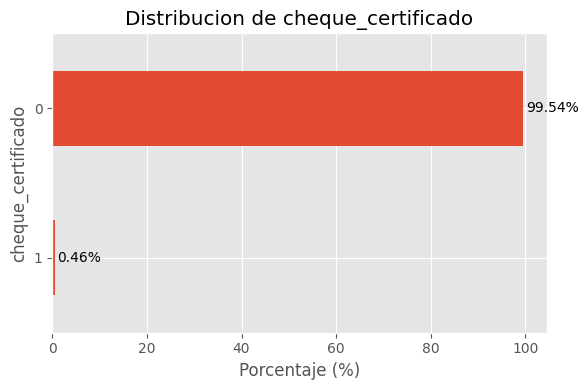

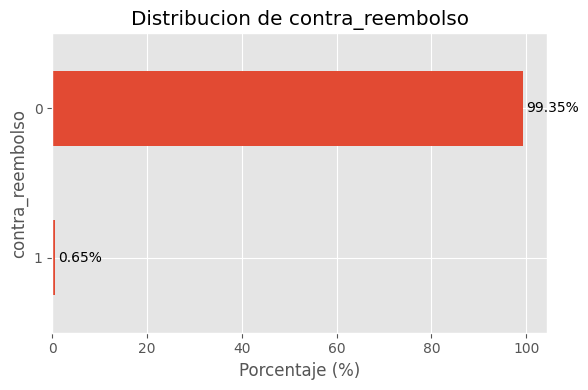

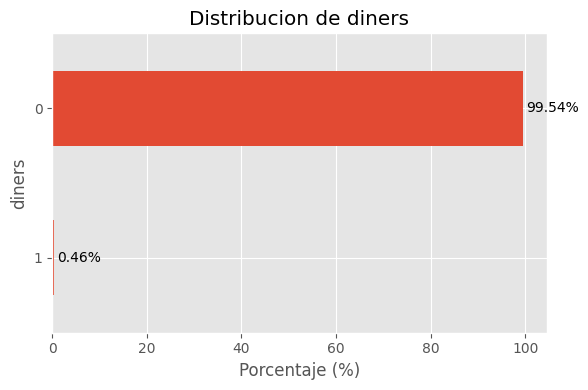

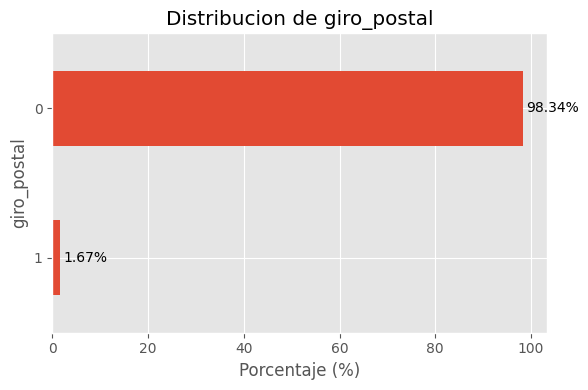

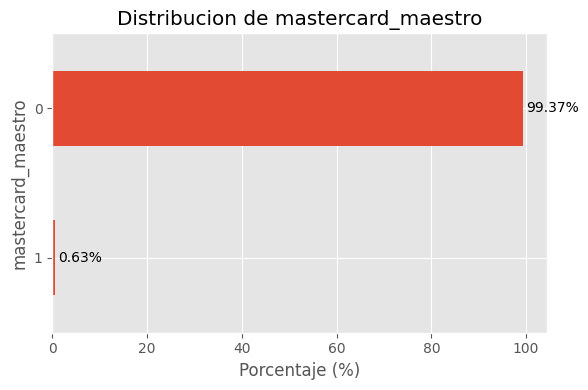

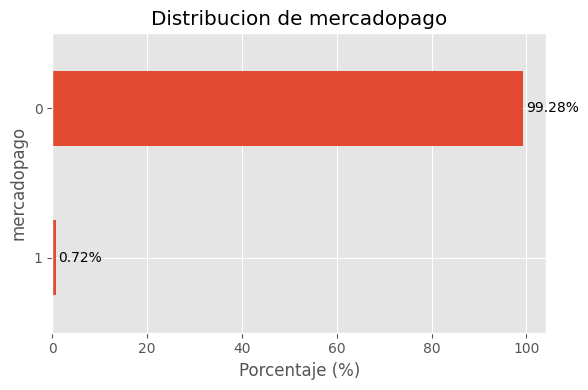

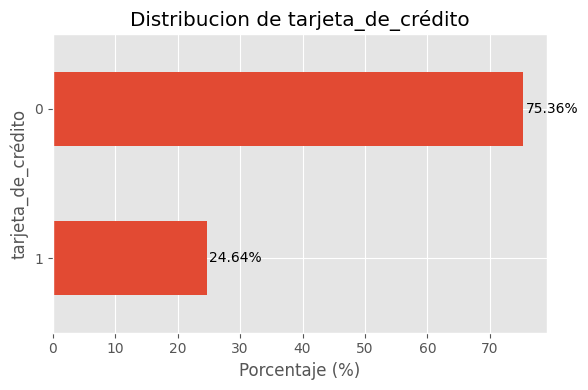

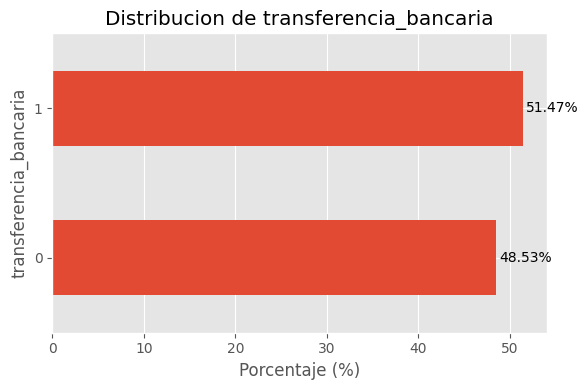

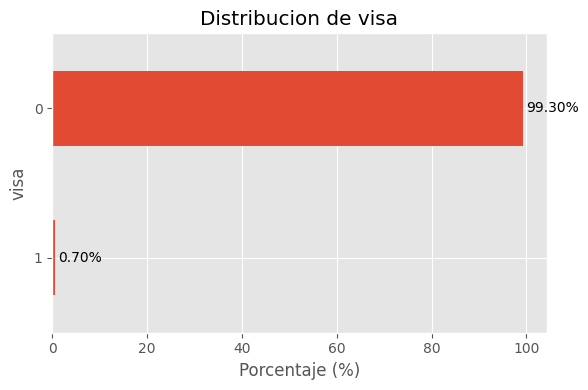

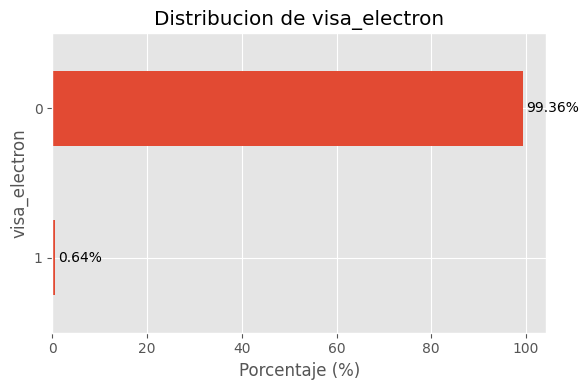

In [19]:
for col in [c for c in df.columns if c.startswith("non_mercado_pago_payment_method")]:
    plot_categorical_dist(
        df=df,
        column=col,
        ylabel=col.replace("non_mercado_pago_payment_methods__", ""),
        title=f"Distribucion de {col.replace('non_mercado_pago_payment_methods__', '')}",
        figsize=(6, 4),
    )

- De los medios de pago diferentes a `MercadoPago`, los mas aceptados son:
    - `Acuerdo con Comprador` (7.99%)
    - `Tarjeta de Credito` (24.64%)
    - `Transferencia Bancaria` (51.47%)
    - `Efectivo` (67.06%)
- Hay otra variable que tambien tiene informacion de `MercadoPago` -> `non_mercado_pago_payment_methods__mercadopago`

In [20]:
df[["accepts_mercadopago", "non_mercado_pago_payment_methods__mercadopago"]].value_counts(dropna=False).to_frame()

count
accepts_mercadopago non_mercado_pago_payment_methods__mercadopago       
True                0                                              97061
False               0                                               2219
True                1                                                720

- Parecen no coincidir, entonces se procedera a eliminar `non_mercado_pago_payment_methods__mercadopago`

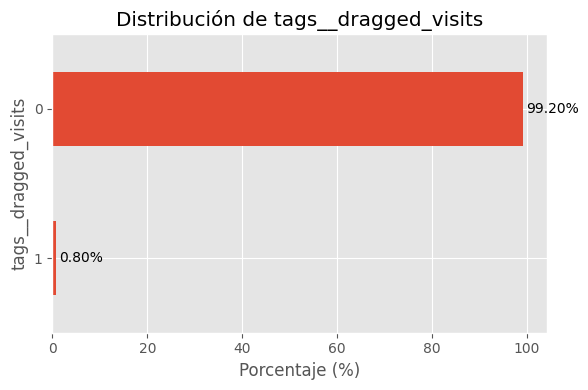

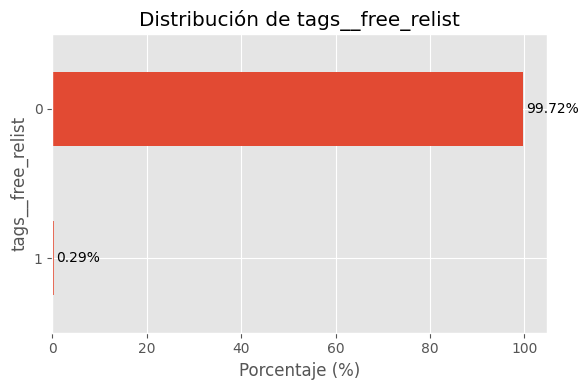

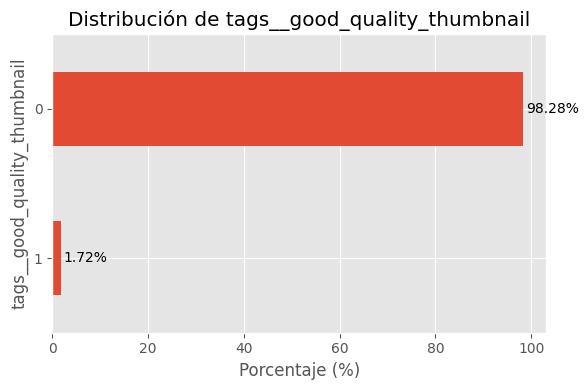

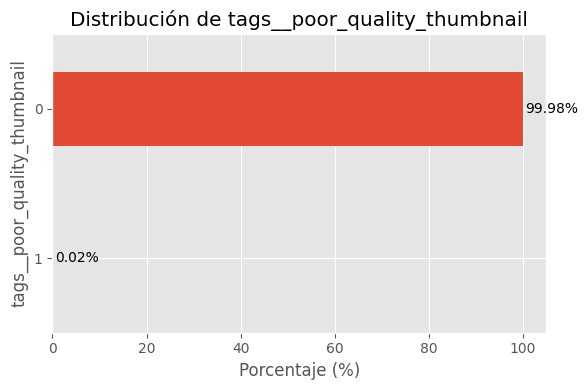

In [21]:
for col in [c for c in df.columns if c.startswith("tags")]:
    plot_categorical_dist(df=df, column=col, figsize=(6, 4))

- Finalmente, tenemos las variables de los tags de las publicaciones. Una proporcion muy poca de las publicaciones tiene estos tags. El tag mas completo es `dragged_bits_and_visits`, presente en el 73.89% de los datos.

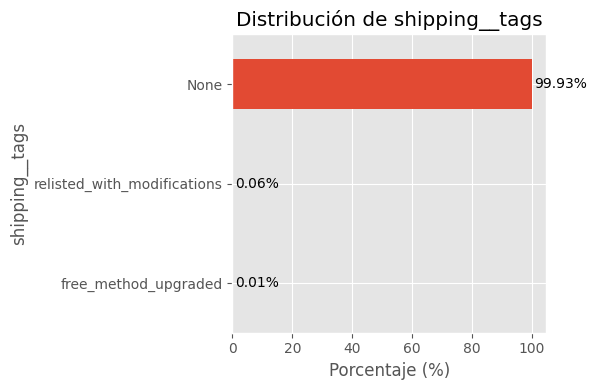

In [22]:
plot_categorical_dist(df=df, column="shipping__tags", figsize=(6, 4))

- Hay muy pocas publicaciones con shipping tags (0.07%)

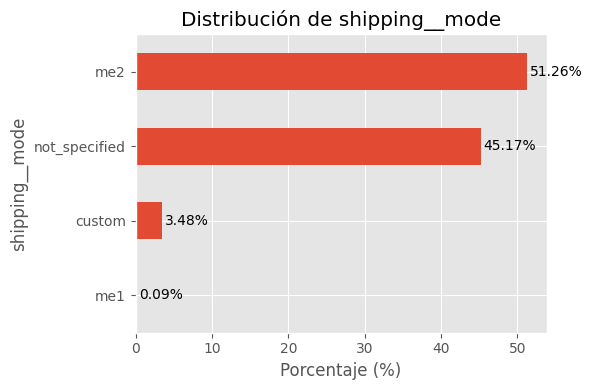

In [23]:
plot_categorical_dist(df=df, column="shipping__mode", figsize=(6, 4))

- La mitad de las publicaciones tienen shipping mode `me2`

### Numericas

#### Enteros

In [24]:
print(f"Numero de vendedores: {df['seller_id'].nunique():,}")

Numero de vendedores: 35,915


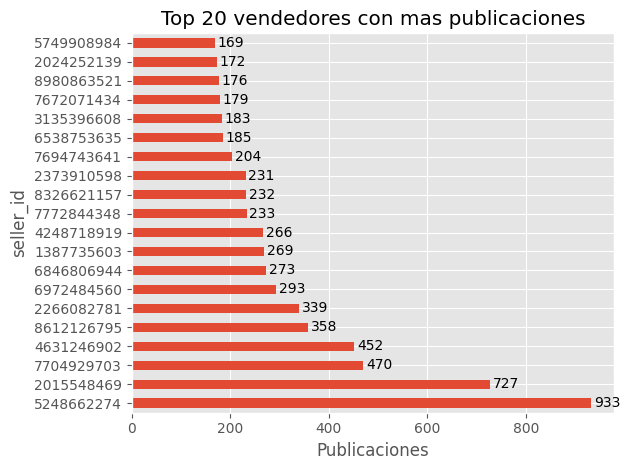

In [25]:
ax = (
    df["seller_id"]
    .value_counts()
    .nlargest(20)
    .round(2)
    .plot(kind="barh", title="Top 20 vendedores con mas publicaciones", xlabel="Publicaciones")
)

for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=2)

plt.tight_layout()
plt.show()

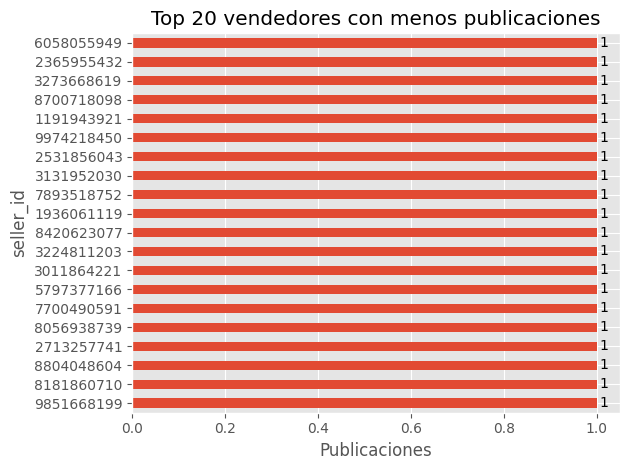

In [26]:
ax = (
    df["seller_id"]
    .value_counts()
    .nsmallest(20)
    .round(2)
    .plot(kind="barh", title="Top 20 vendedores con menos publicaciones", xlabel="Publicaciones")
)

for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=2)

plt.tight_layout()
plt.show()

count    100000.000000
mean         35.093370
std         421.076196
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        9999.000000
Name: initial_quantity, dtype: float64

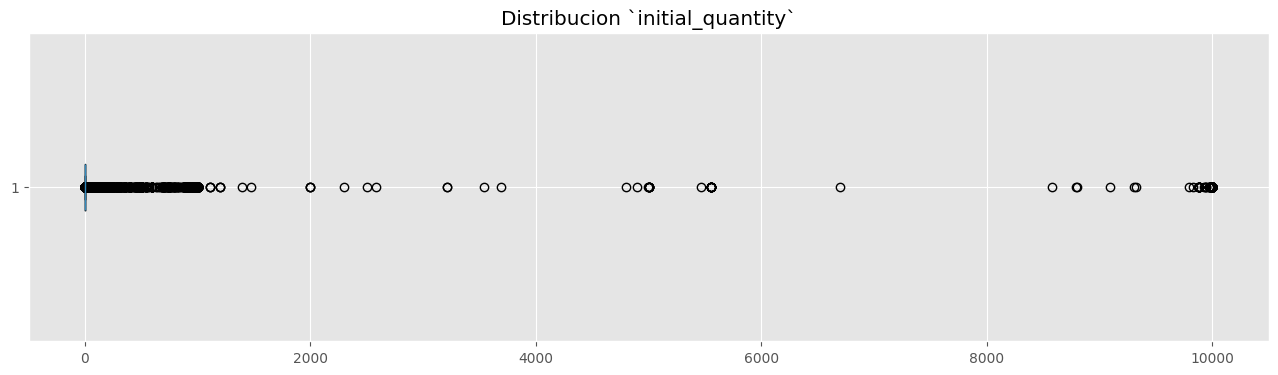

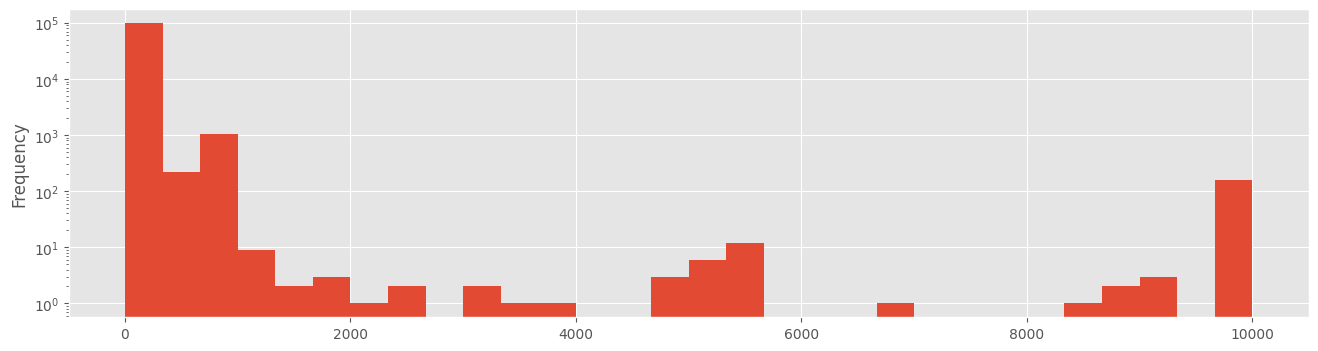

In [27]:
display(df["initial_quantity"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["initial_quantity"], vert=False)
plt.title("Distribucion `initial_quantity`")
plt.show()

plt.figure(figsize=(16, 4))
df["initial_quantity"].plot(kind="hist", logy=True, bins=30)
plt.show()

count    100000.000000
mean          2.396990
std          42.685077
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        8676.000000
Name: sold_quantity, dtype: float64

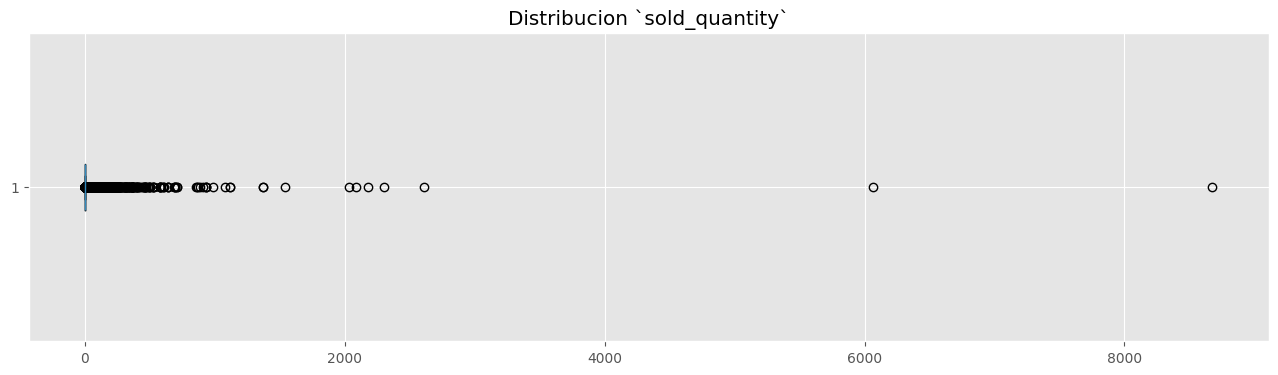

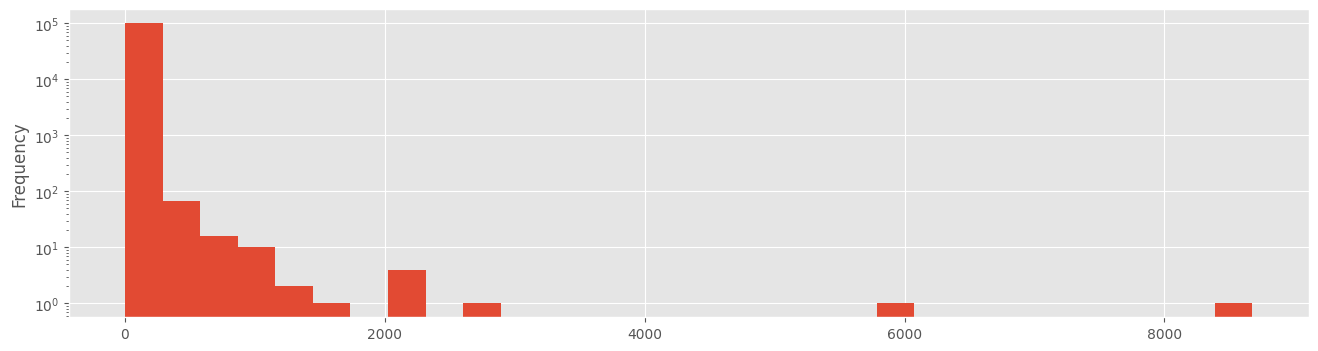

In [28]:
display(df["sold_quantity"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["sold_quantity"], vert=False)
plt.title("Distribucion `sold_quantity`")
plt.show()

plt.figure(figsize=(16, 4))
df["sold_quantity"].plot(kind="hist", logy=True, bins=30)
plt.show()

count    100000.000000
mean         34.842380
std         420.808403
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        9999.000000
Name: available_quantity, dtype: float64

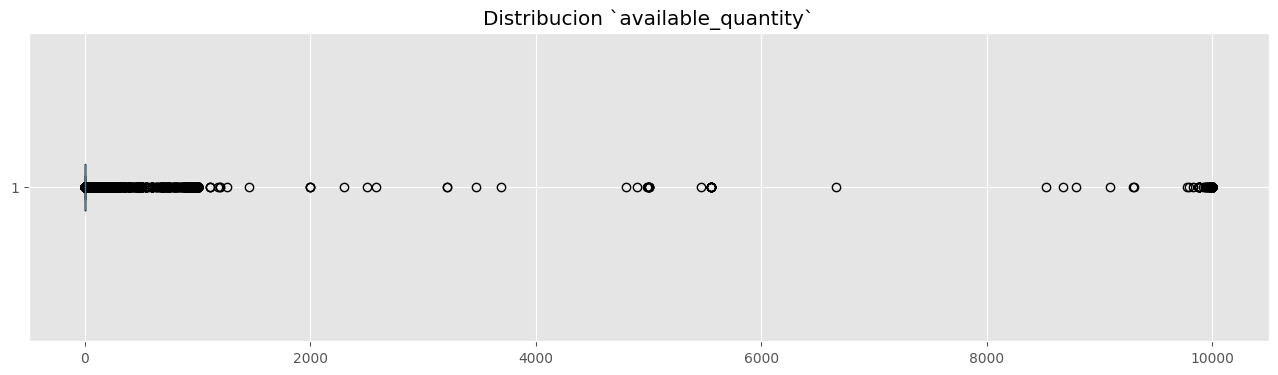

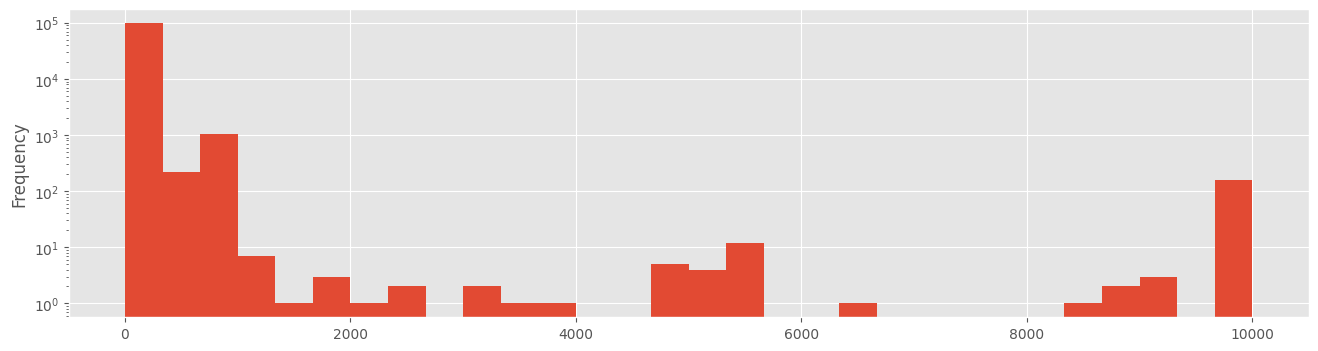

In [29]:
display(df["available_quantity"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["available_quantity"], vert=False)
plt.title("Distribucion `available_quantity`")
plt.show()

plt.figure(figsize=(16, 4))
df["available_quantity"].plot(kind="hist", logy=True, bins=30)
plt.show()

count    100000.000000
mean          2.931360
std           2.102825
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          36.000000
Name: n_pictures, dtype: float64

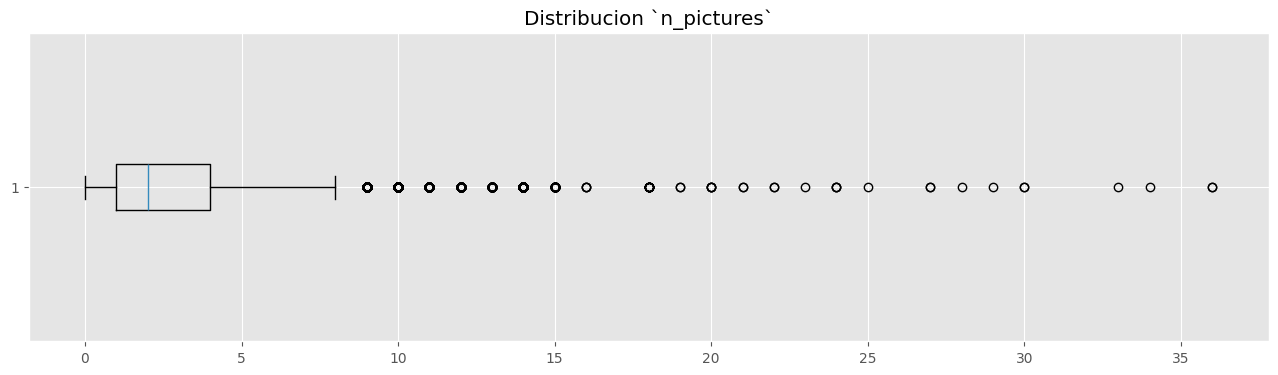

In [30]:
display(df["n_pictures"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["n_pictures"], vert=False)
plt.title("Distribucion `n_pictures`")
plt.show()

plt.figure(figsize=(16, 4))
df["n_pictures"].plot(kind="hist", logy=True, bins=30)
plt.show()

- Parecen existir outliers en la variable `initial_quantity`, `available_quantity`, `sold_quantity` y `n_pictures`. Todas tienen una distribucion sesgada hacia la derecha.

#### Floats

count    1.000000e+05
mean     5.252423e+04
std      8.623127e+06
min      8.400000e-01
25%      9.000000e+01
50%      2.500000e+02
75%      8.000000e+02
max      2.222222e+09
Name: base_price, dtype: float64

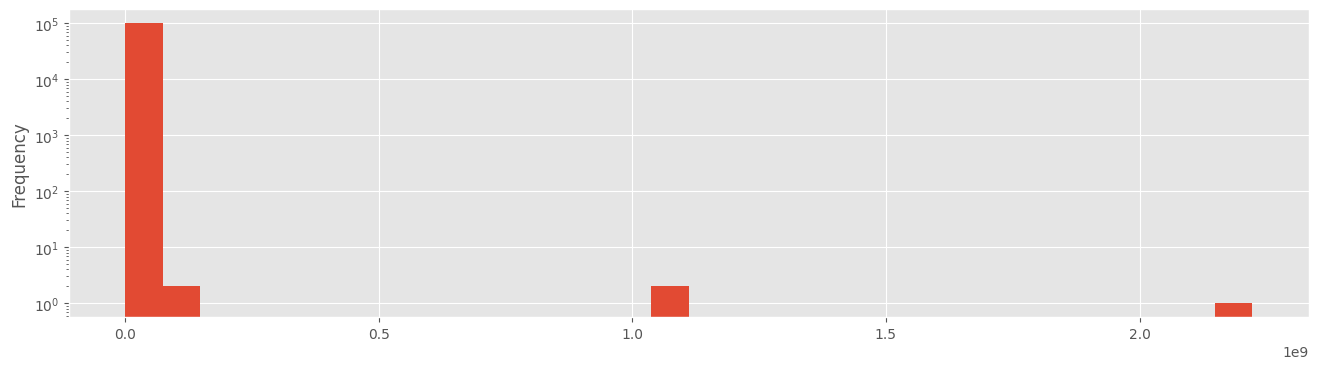

In [31]:
display(df["base_price"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["base_price"], vert=False)
plt.title("Distribucion `base_price`")
plt.show()

plt.figure(figsize=(16, 4))
df["base_price"].plot(kind="hist", logy=True, bins=30)
plt.show()

count    1.000000e+05
mean     5.252433e+04
std      8.623127e+06
min      8.400000e-01
25%      9.000000e+01
50%      2.500000e+02
75%      8.000000e+02
max      2.222222e+09
Name: price, dtype: float64

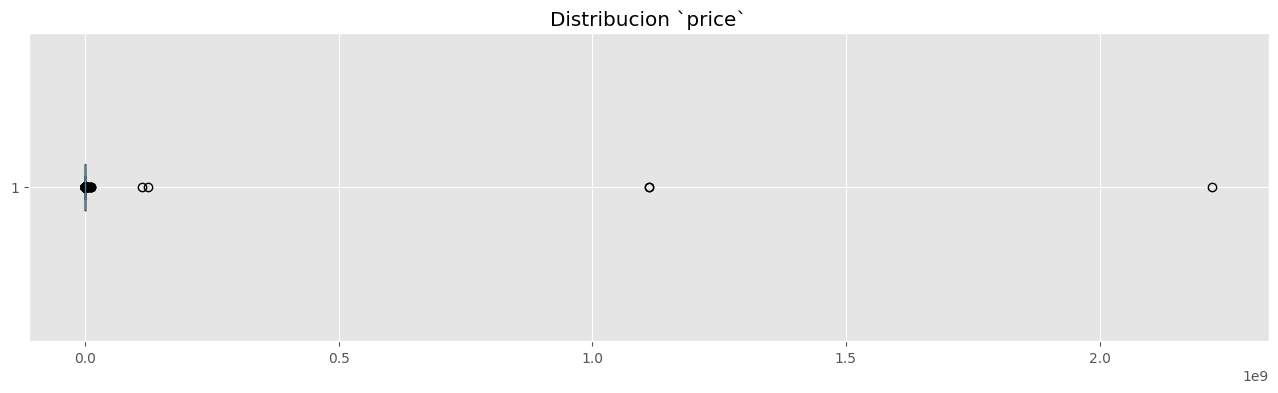

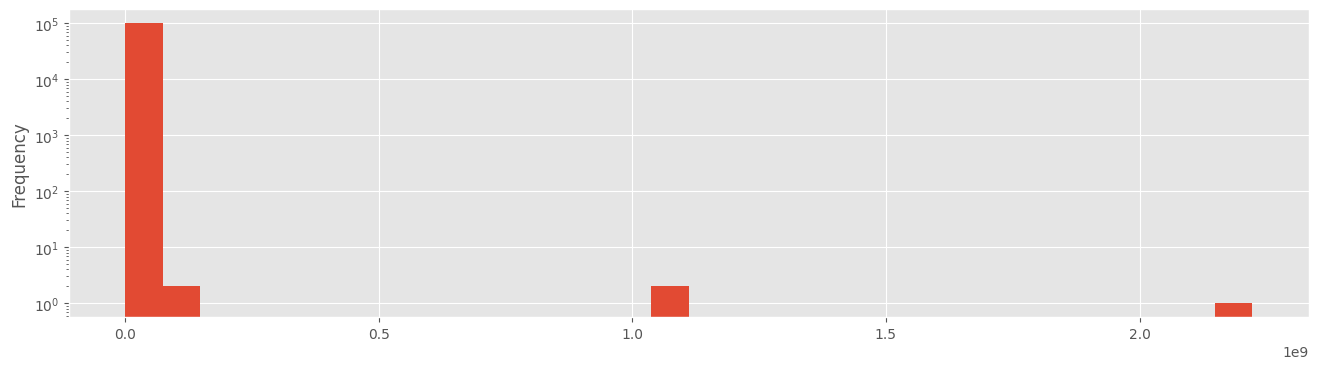

In [32]:
display(df["price"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["price"], vert=False)
plt.title("Distribucion `price`")
plt.show()

plt.figure(figsize=(16, 4))
df["price"].plot(kind="hist", logy=True, bins=30)
plt.show()

count      143.000000
mean      1593.341958
std       2245.798072
min        120.000000
25%        449.000000
50%        858.000000
75%       1500.000000
max      13999.000000
Name: original_price, dtype: float64

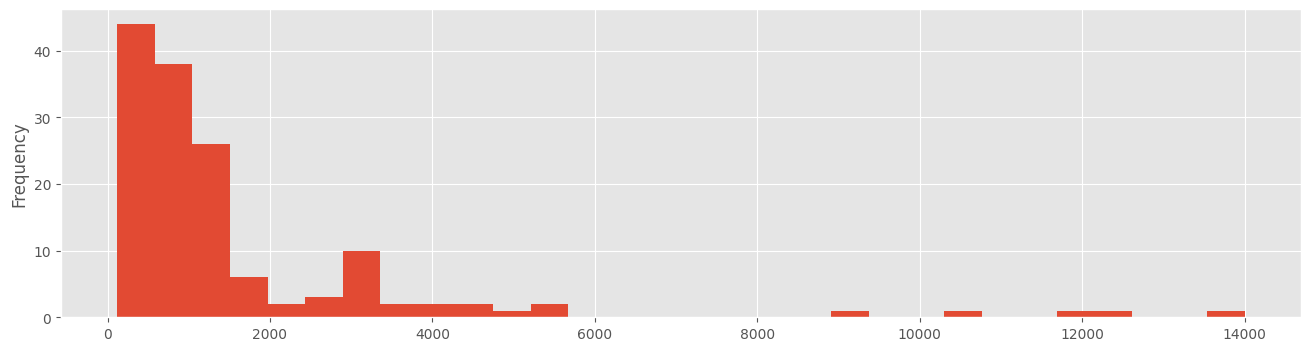

In [33]:
display(df["original_price"].describe())
plt.figure(figsize=(16, 4))
plt.boxplot(x=df["original_price"], vert=False)
plt.title("Distribucion `original_price`")
plt.show()

plt.figure(figsize=(16, 4))
df["original_price"].plot(kind="hist", logy=False, bins=30)
plt.show()

In [34]:
print(f"Numero de tiendas oficiales: {df['official_store_id'].nunique():,}")

Numero de tiendas oficiales: 198


In [35]:
print(f"Numero de catalogos de productos: {df['catalog_product_id'].nunique():,}")

Numero de catalogos de productos: 9


### Strings

Sin garantía
si
3 Meses del fabricante
Todos nuestros productos cuentan con garantia escrita del fabricante. Compre con confianza, mas de 10 años en el rubro nos avalan
SERVICIO TECNICO POSTERIOR BRINDADO POR PROFESIONALES
Mis Calificaciones!
Si
Todos los productos en Ofi-Com Amoblamientos tienen 12 meses de garantía
Se garantiza el estado del material tal como se describe en el artículo.
Sí


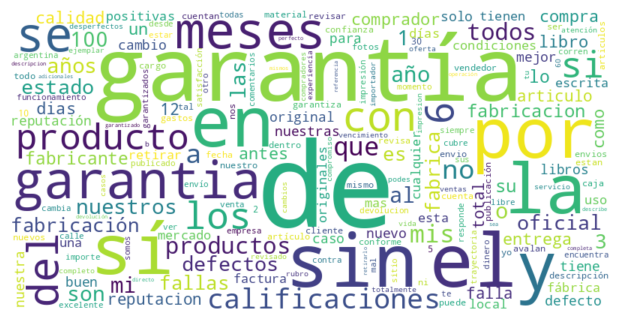

In [36]:
print("\n".join(df["warranty"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["warranty"].str.len().plot(kind="hist", title="Distribucion de longitud de mensaje del campo de Garantia")
plt.show()

create_wordcloud(df, "warranty")
plt.show()

- La variable de `Garantia` contiene lenguaje natural, y no se cumple la condicion de que si hay mensaje hay garantia. Hay casos donde el mensaje es "Sin garantía", "Local a la calle", en los que no refleja una garantia valida.

GAC6A
WGPLA
WGPLA
MISCR
MOSH6
WGPLA
15H9O
MOSH6
MOSH6
WGPLA


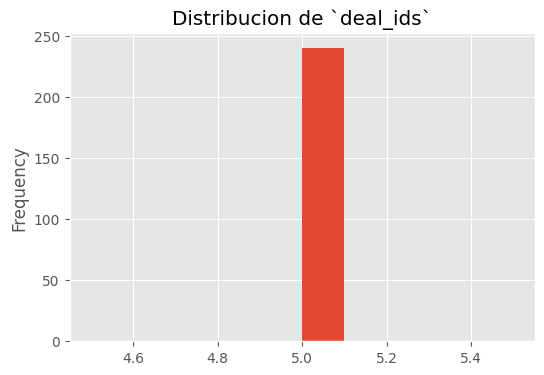

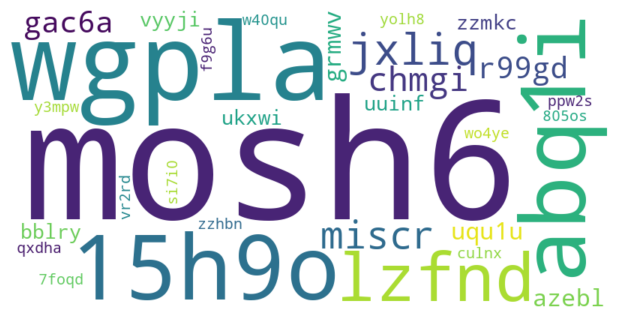

In [37]:
print("\n".join(df["deal_ids"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["deal_ids"].str.len().plot(kind="hist", title="Distribucion de `deal_ids`")
plt.show()

create_wordcloud(df, "deal_ids")
plt.show()

- En `deal_ids` todos son indicadores unicos de 5 caracteres. Sin embargo, no es claro a que hace referencia esta variable.

MLA7678067150
MLA5531286390
MLA3469751454
MLA6956073219
MLA3852075354
MLA4819507992
MLA3912416838
MLA4121502553
MLA7045544930
MLA3074402425


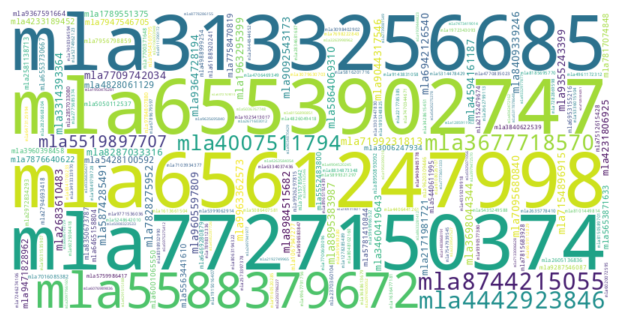

In [38]:
print("\n".join(df["parent_item_id"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["parent_item_id"].str.len().plot(kind="hist", title="Distribucion de `parent_item_id`")
plt.show()

create_wordcloud(df, "parent_item_id")
plt.show()

- En `parent_item_id` todos son indicadores unicos de 13 caracteres que empienzan por "MLA" -> Mercado Libre Argentina

In [39]:
print("\n".join(df["category_id"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["category_id"].str.len().plot(kind="hist", title="Distribucion de `category_id`")
plt.show()

create_wordcloud(df, "category_id")
plt.show()

MLA21086
MLA1227
MLA31336
MLA4690
MLA61010
MLA15157
MLA6009
MLA352345
MLA24351
MLA357083


- En `category_id` todos son indicadores unicos de 7,8 o 9 caracteres que empienzan por "MLA"

MLA3283112727-926023411
MLA2341483191-934175749
MLA2781902554-824665535
MLA6822595067-932905475
MLA2437850827-917998362
MLA9810519291-929870576
MLA1365750059-922370976
MLA2811084851-905009519
MLA3150968267-923779831
MLA9823274836-912226767


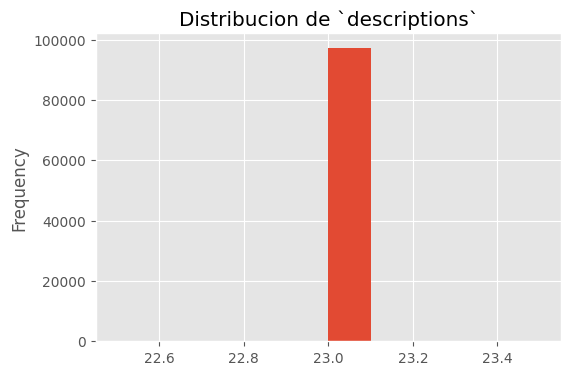

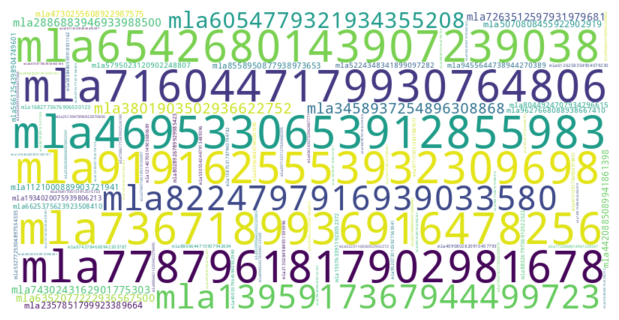

In [40]:
print("\n".join(df["descriptions"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["descriptions"].str.len().plot(kind="hist", title="Distribucion de `descriptions`")
plt.show()

create_wordcloud(df, "descriptions")
plt.show()

- En `descriptions` todos son indicadores unicos de 23 caracteres que empienzan por "MLA"

In [41]:
print(f"Numero de ids diferentes {df['id'].nunique():,}")

Numero de ids diferentes 100,000


`id` es el identificador unico de cada fila en el dataset.

In [42]:
for each in ["thumbnail", "secure_thumbnail", "permalink", "video_id"]:
    print(each.capitalize())
    print("Sample: ")
    print(df[each].dropna().sample(10).tolist(), end="\n\n")

Thumbnail
Sample: 
['http://mla-s1-p.mlstatic.com/3946-MLA4825709118_082013-I.jpg', 'http://mla-s2-p.mlstatic.com/20552-MLA7192271191_112014-I.jpg', 'http://mla-s2-p.mlstatic.com/13587-MLA1033550264_092012-I.jpg', 'http://mla-s1-p.mlstatic.com/922501-MLA6851897719_072015-I.jpg', 'http://mla-s2-p.mlstatic.com/22287-MLA6263180684_012015-I.jpg', 'http://mla-s1-p.mlstatic.com/822801-MLA3641925722_092015-I.jpg', 'http://mla-s1-p.mlstatic.com/21882-MLA8288865160_122014-I.jpg', 'http://mla-s2-p.mlstatic.com/221701-MLA4461485960_082015-I.jpg', 'http://mla-s2-p.mlstatic.com/996401-MLA5816132960_072015-I.jpg', 'http://mla-s1-p.mlstatic.com/13629-MLA7698631536_3468-I.jpg']

Secure_thumbnail
Sample: 
['https://a248.e.akamai.net/mla-s1-p.mlstatic.com/3706-MLA8165932029_082013-I.jpg', 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/801901-MLA1346795509_092015-I.jpg', 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/12211-MLA6916539062_032014-I.jpg', 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/

- Para las columnas ``thumbnail``, ``secure_thumbnail`` y ``permalink``, los links parecen no funcionar, por ende se descartaran del analisis. Por otro lado `video_id` parece ser un identificador unico de las publicaciones que tienen video disponible.

Ps3 500gb Nuevas Caja Cerrada. Oferta!!
Yu Yu Hakusho Tomo 14 Manga Ivrea - Random Comics
Operacion Masacre - Rodolfo Walsh -b62
Joys And Sorrows Reflection Pablo Casals As Told Albert Kahn
Nueva Cifra 3 Matematica - Mun -  -nuevo- #di16
Combo De Griferias Fv Vermont Lavatorio + Bidet + Bañera
Mensajes De La Virgen Del Rosario San Nicolas Anexo 1986
Funda Silicona Tpu Para Samsung S3 I9300
Rudy - Eliahu Toker Odiar Es Pertenecer Y Otros Chistes
Carcasa Funda Plastico Santo Para Iphone 4/4s


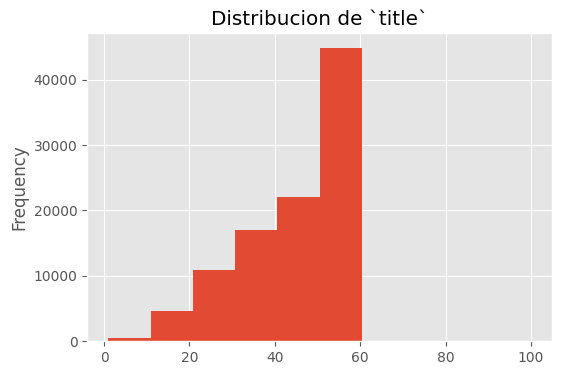

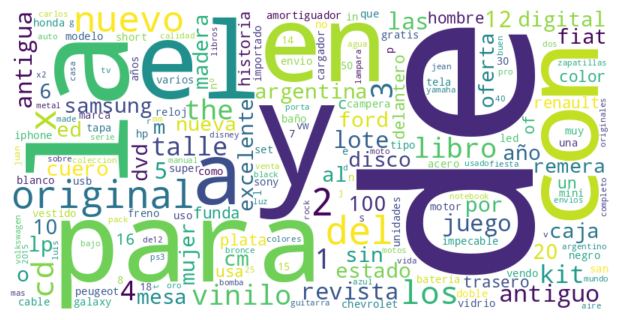

In [43]:
print("\n".join(df["title"].dropna().sample(10).tolist()))

plt.figure(figsize=(6, 4))
df["title"].str.len().plot(kind="hist", title="Distribucion de `title`")
plt.show()

create_wordcloud(df, "title")
plt.show()

- La variable de `title` contiene lenguaje natural que describe el producto, tiene entre 0 y 60 caracteres. 

### Fechas

In [44]:
df["date_created"].describe()

count                                 100000
mean     2015-09-16 05:37:30.126649856+00:00
min                2013-05-21 04:22:35+00:00
25%      2015-09-01 21:00:31.750000128+00:00
50%         2015-09-17 20:31:53.500000+00:00
75%                2015-10-02 15:29:44+00:00
max                2015-10-15 09:14:30+00:00
Name: date_created, dtype: object

- Publicaciones creadas entre Mayo del 2013 y Octubre del 2015.

In [45]:
df["last_updated"].describe()

count                                 100000
mean     2015-09-23 12:22:31.871019520+00:00
min                2014-11-11 20:15:04+00:00
25%         2015-09-11 12:08:26.500000+00:00
50%                2015-09-27 03:01:21+00:00
75%      2015-10-07 18:08:51.750000128+00:00
max         2015-10-15 10:48:48.026000+00:00
Name: last_updated, dtype: object

In [46]:
df["stop_time"].describe()

count                           100000
mean     2015-11-16 03:53:10.695500032
min                2015-10-14 11:51:37
25%                2015-10-31 17:11:45
50%         2015-11-16 02:12:30.500000
75%      2015-12-01 00:45:32.249999872
max                2024-11-04 14:55:51
Name: stop_time, dtype: object

In [47]:
df["start_time"].describe()

count                           100000
mean     2015-09-16 05:48:30.129960192
min                2013-05-21 04:22:35
25%                2015-09-01 21:04:33
50%                2015-09-17 20:35:36
75%      2015-10-02 15:34:33.750000128
max                2015-10-15 09:14:30
Name: start_time, dtype: object

In [48]:
df["date_created"].dt.date.value_counts().sort_index().plot(kind="line", figsize=(20, 4))
plt.title("Publicaciones creadas")
plt.xticks(rotation=45)
plt.show()

## Analisis Multivariado

#### Numericas

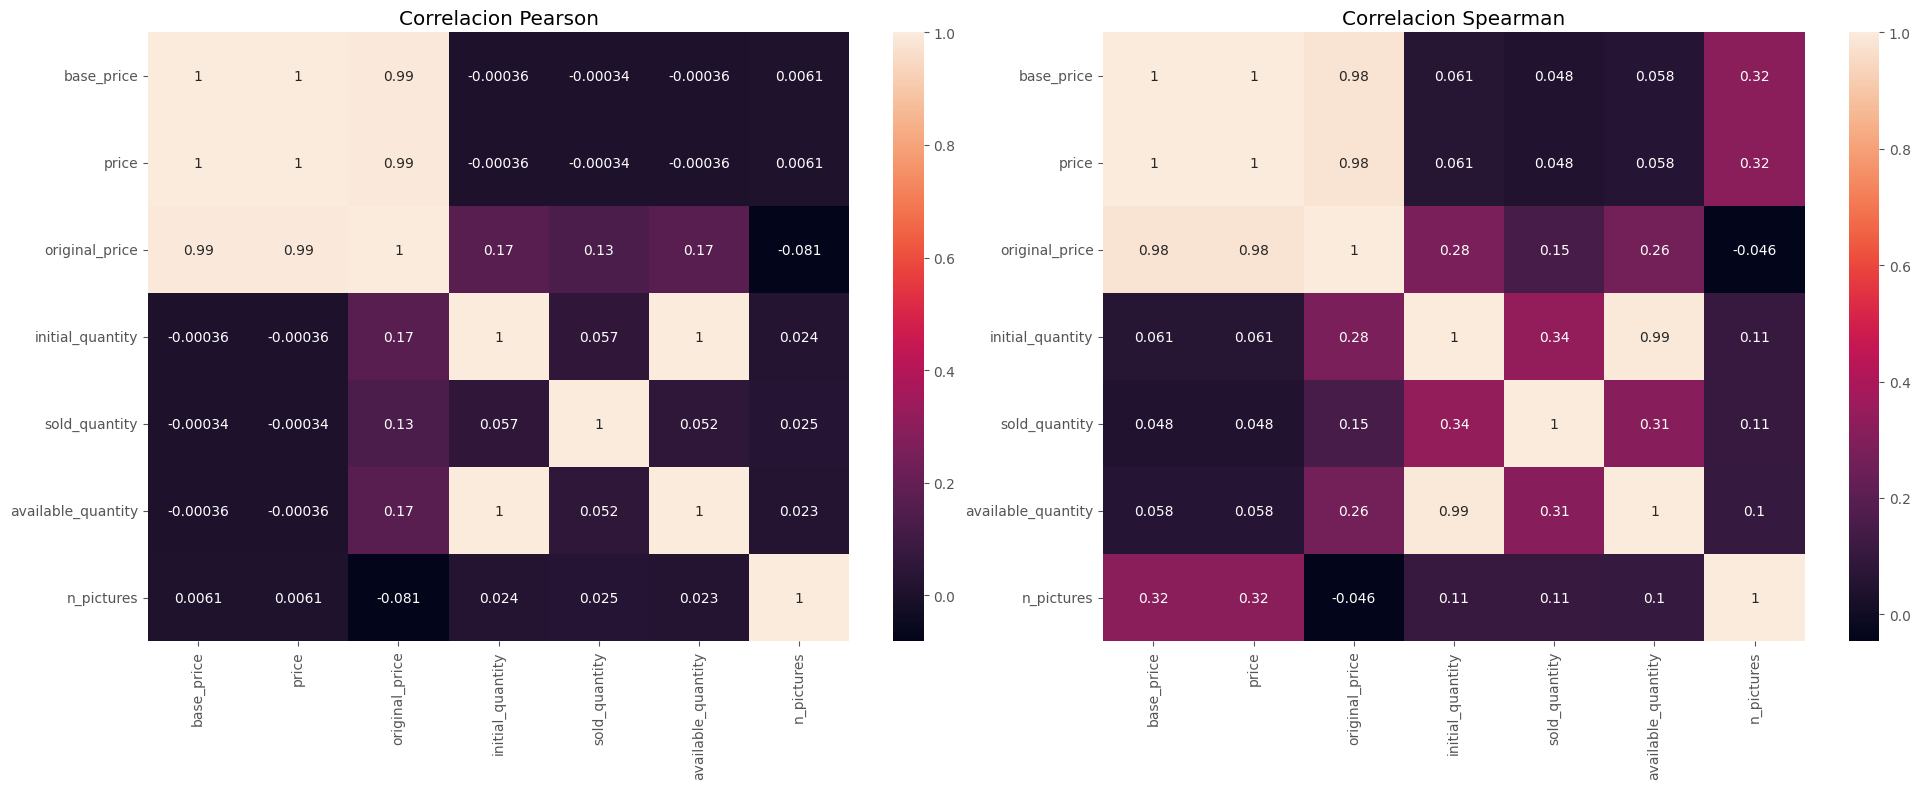

In [50]:
# Seleccionar variables numericas -> Se excluyen dummy e ids
numbers: list = df.select_dtypes("number").columns
numbers = [
    c for c in numbers if all([not c.startswith("tags"), not c.startswith("non_mercado_pago_payment_method"), "id" not in c])
]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.flatten()
for idx, method in enumerate(["pearson", "spearman"]):
    corr = df[numbers].corr(method=method)
    sns.heatmap(data=corr, annot=True, ax=ax[idx])
    ax[idx].set_title(f"Correlacion {method.capitalize()}")
    fig.tight_layout()
    fig.show()

- Las variables de precio `price`, `base_price` y `original_price` estan perfectamente correlacionadas (+).
- Las variables de cantidad `initial_quantity` y `available_quantity` estan perfectamente correlacionadas (+).
- Cuando analizamos la correlacion Spearman, vemos que aparecen ciertas correlaciones leves positivas que en Pearson no aparecian, por ejemplo `n_pictures` y `base_price` | ``price``, o `sold_quantity` y `initial_quantity` | `available_quantity`. Esto nos da indicios de que pueden existir relaciones monotonicas entre las variables, no necesariamente lineales.

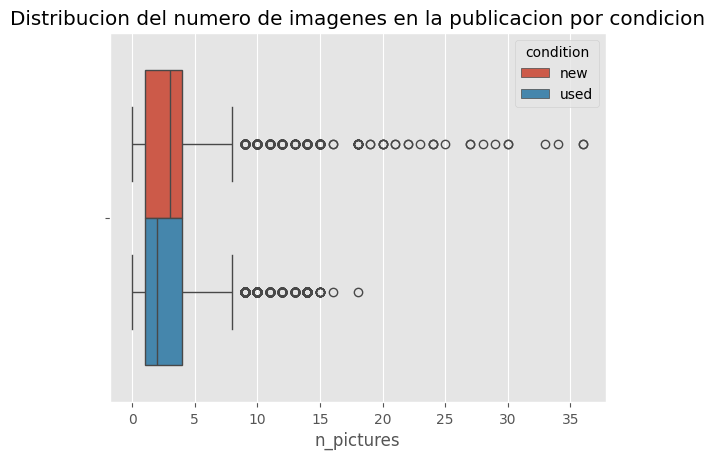

In [51]:
sns.boxplot(data=df, x="n_pictures", hue="condition")
plt.title("Distribucion del numero de imagenes en la publicacion por condicion")
plt.show()

- Las publicaciones de productos nuevos tienen una mediana de numero de imagenes (3) levemente mas alta que las de productos usados (2).

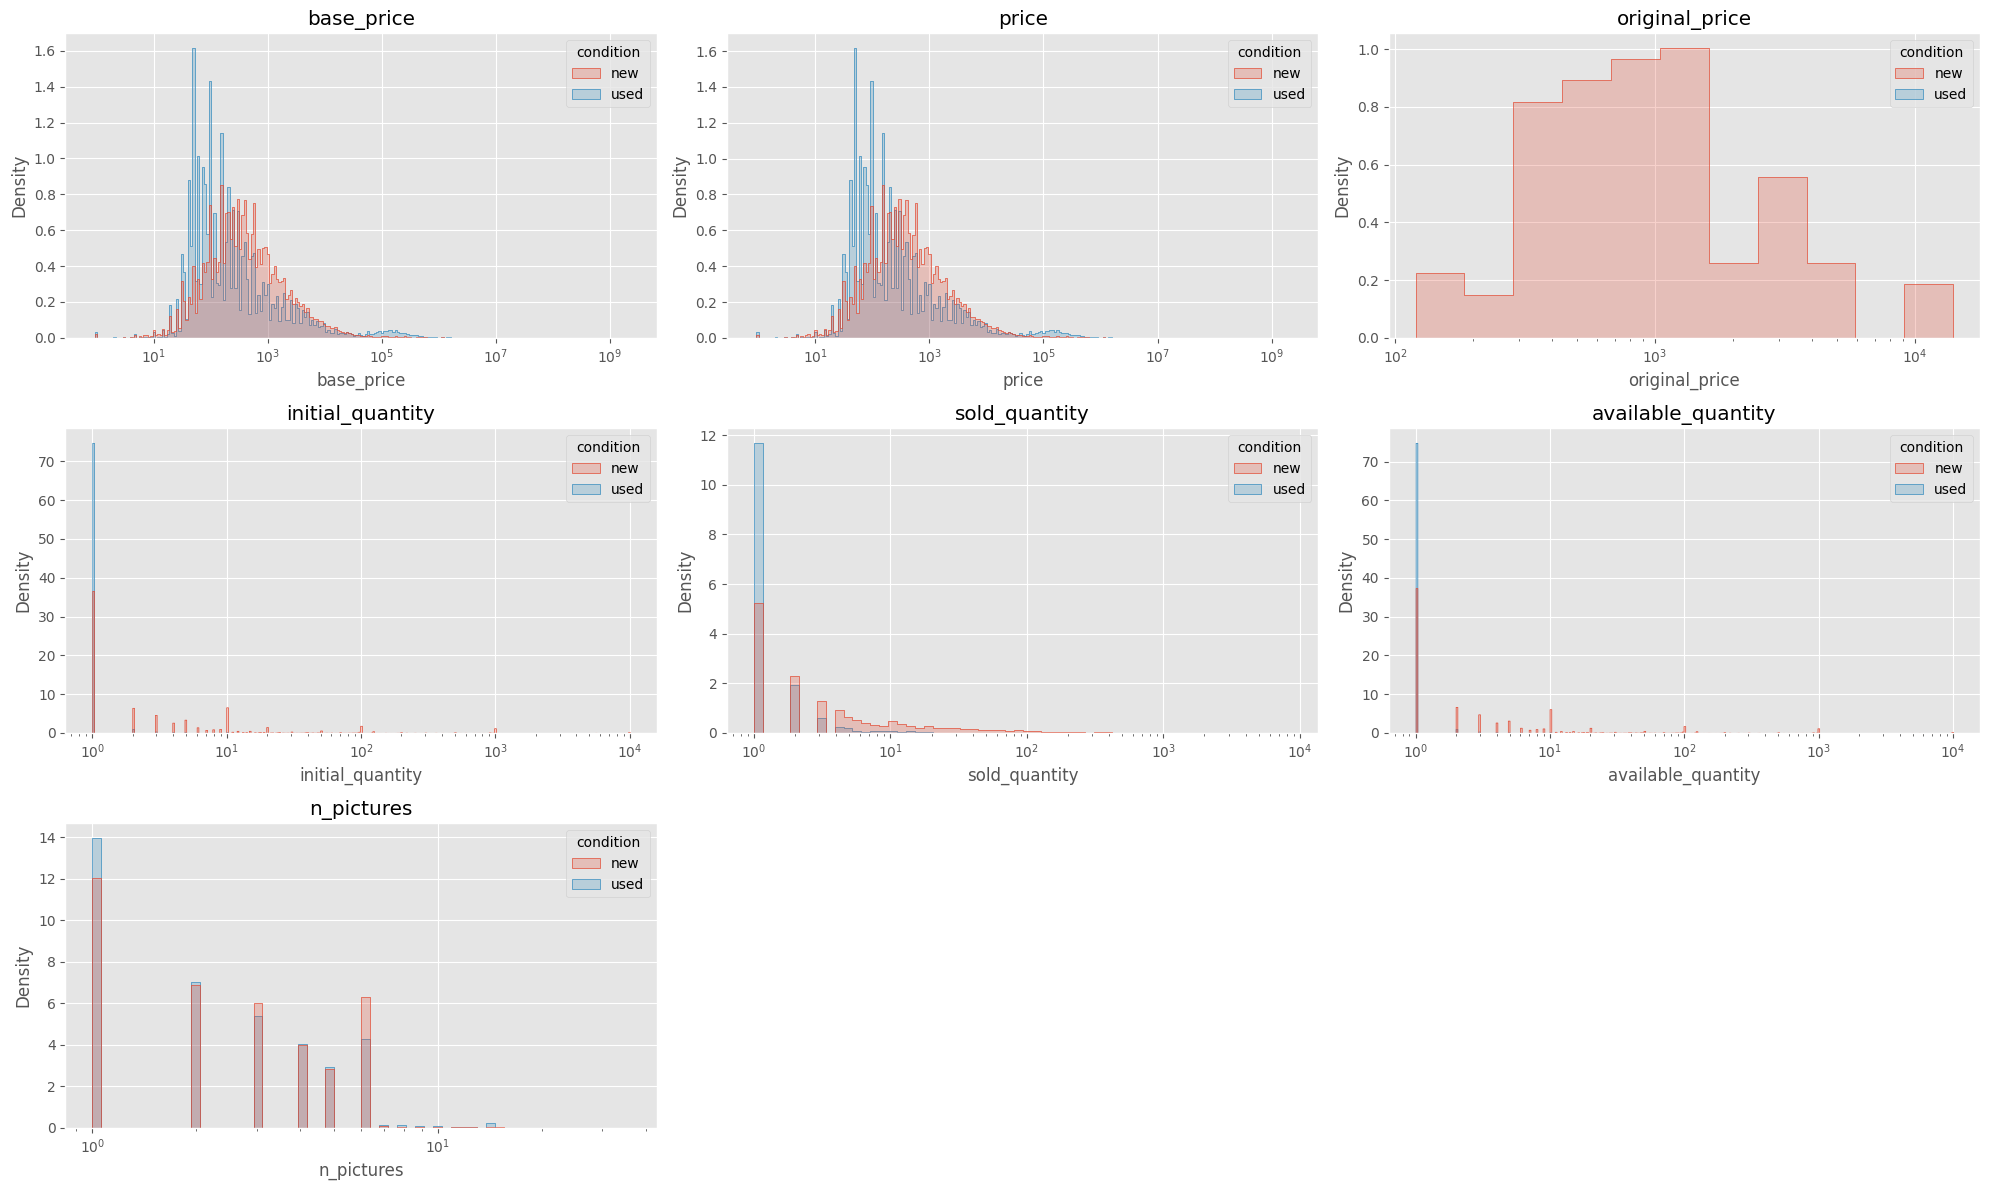

In [67]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()

for idx, var in enumerate(numbers):
    sns.histplot(data=df, x=var, hue="condition", log_scale=True, stat="density", common_norm=False, element="step", ax=ax[idx])
    ax[idx].set_title(var)

for i in range(len(numbers), len(ax)):
    fig.delaxes(ax[i])

fig.tight_layout()
plt.show()

- En terminos de precios (`base_price` y `price`) vemos la distribucion de los precios de los productos usados esta mas sesgada en comparacion con la de los productos nuevos que parece seguir una distribucion normal -> se podria interpretar como precios mas economicos para los productos usados.
- `original_price` solo aparece cuando los productos son nuevos -> Posible target leakage !!
- En terminos de cantidades, ocurre un fenomeno similar que con los precios, ya que tenemos mayor concentracion de densidad en los valores de la cola izquierda de la distribucion.

In [181]:
# Target Leakage
df.groupby(by="condition", observed=True, dropna=False)["original_price"].count()

condition
new     143
used      0
Name: original_price, dtype: int64

- Si bien `original_price` aparece solo cuando los productos son nuevos, solo aparece en 143 publicaciones de productos nuevos.

#### Categoricas

In [114]:
df.groupby(by="listing_type_id", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`listing_type_id` por tipo de producto.", figsize=(6, 4))
plt.show()

- La categoria gratis tiene una proporcion significativamente mayor de productos usados que de productos nuevos. Por el contrario, las categorias de oro tienen una proporcion mayor de productos nuevos.
- A medida de que se sube de categoria, mayor numero de productos nuevos.
- Gold premium es la excepcion a la regla.

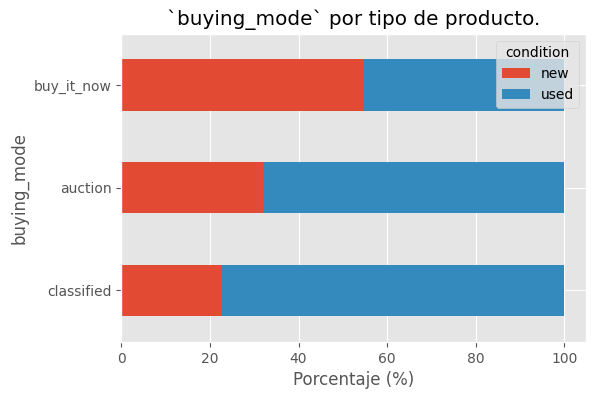

In [115]:
df.groupby(by="buying_mode", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`buying_mode` por tipo de producto.", figsize=(6, 4))
plt.show()

- Subastas y Clasificados tienen mayor proporcion de productos usados.

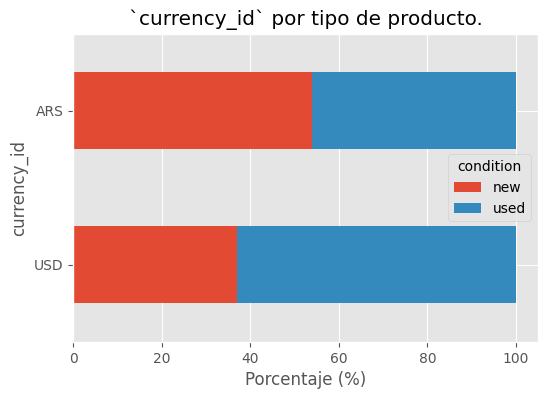

In [116]:
df.groupby(by="currency_id", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`currency_id` por tipo de producto.", figsize=(6, 4))
plt.show()

- Mayor proprocion de productos usados estan listados con precio en dolares.

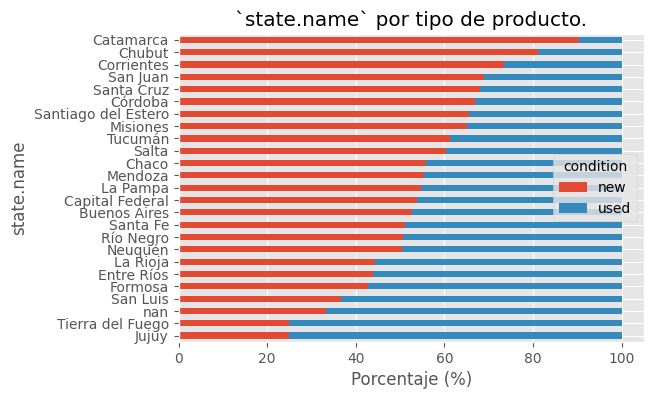

In [117]:
df.groupby(by="state.name", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`state.name` por tipo de producto.", figsize=(6, 4))
plt.show()

- Las provincias que no estan tan bien representadas en los datos, tienen proporciones sesgadas a una clase en comparacion con `CABA` y `Provincia de Buenos Aires`

In [119]:
df.groupby(by="status", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`status` por tipo de producto.", figsize=(6, 4))
plt.show()

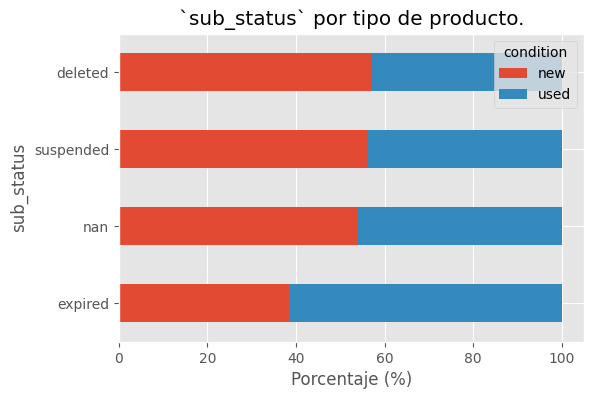

In [120]:
df.groupby(by="sub_status", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`sub_status` por tipo de producto.", figsize=(6, 4))
plt.show()

#### Booleanos

In [121]:
df.groupby(by="automatic_relist", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`automatic_relist` por tipo de producto.", figsize=(6, 4))
plt.show()

- Productos con relisteo automatico son nuevos en su mayoria

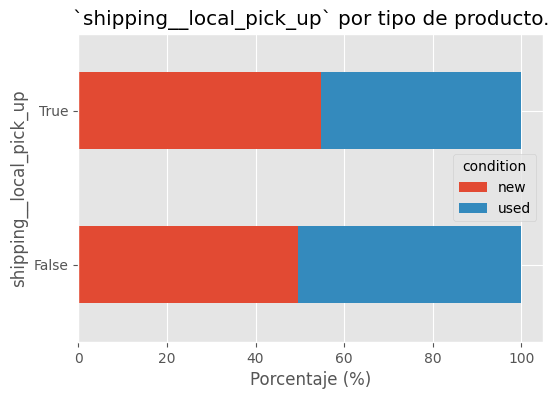

In [122]:
df.groupby(by="shipping__local_pick_up", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`shipping__local_pick_up` por tipo de producto.", figsize=(6, 4))
plt.show()

In [123]:
df.groupby(by="shipping__free_shipping", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`shipping__free_shipping` por tipo de producto.", figsize=(6, 4))
plt.show()

- Free Shiping en su mayoria se da a productos nuevos.

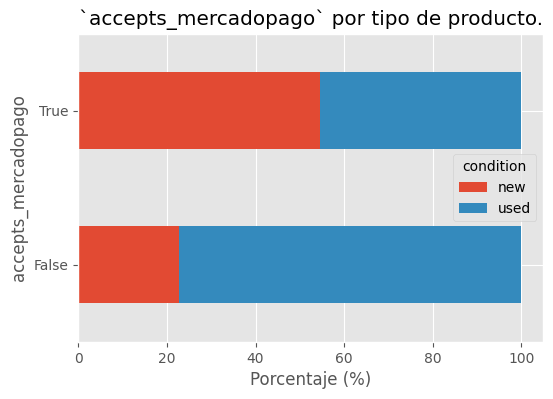

In [125]:
df.groupby(by="accepts_mercadopago", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`accepts_mercadopago` por tipo de producto.", figsize=(6, 4))
plt.show()

- Mayor proporcion de productos usados cuando no se acepta mercadopago.

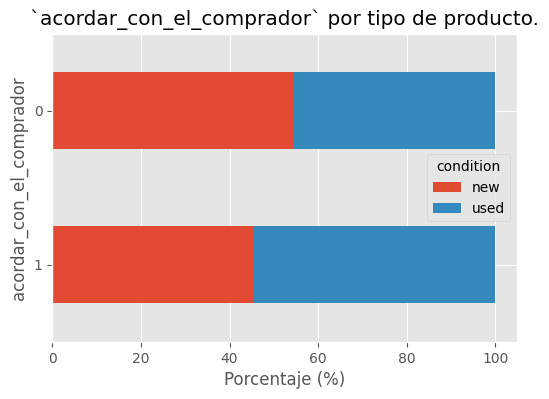

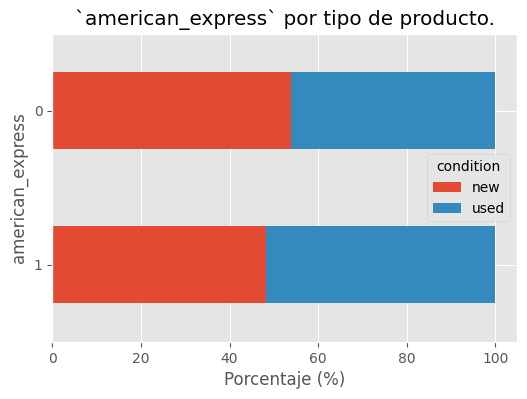

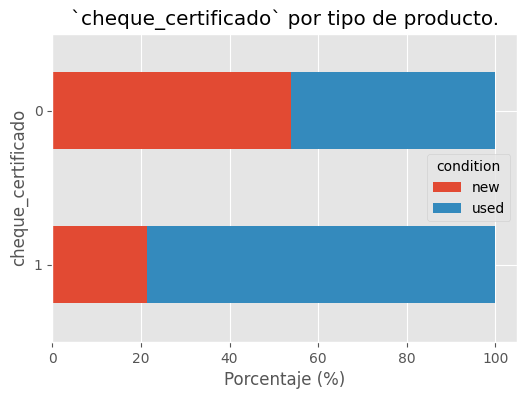

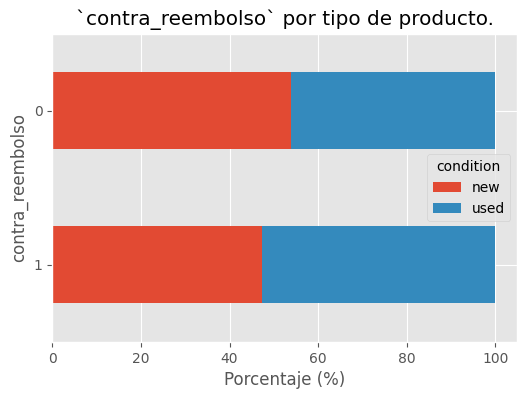

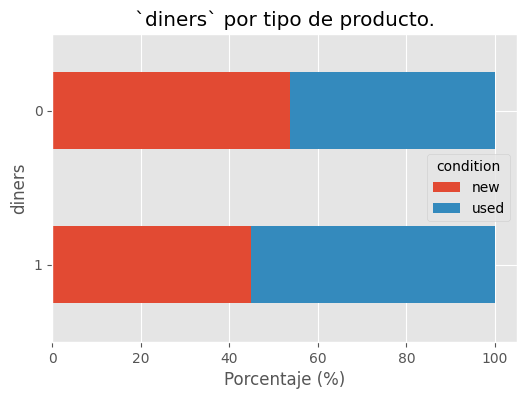

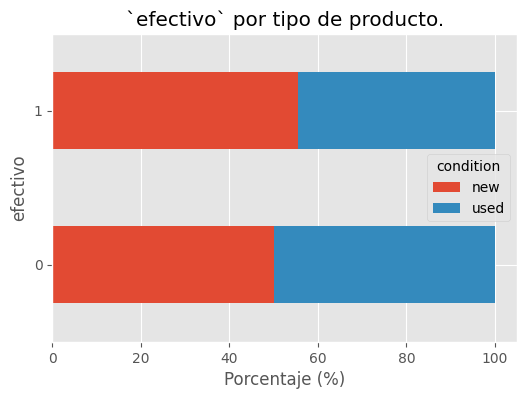

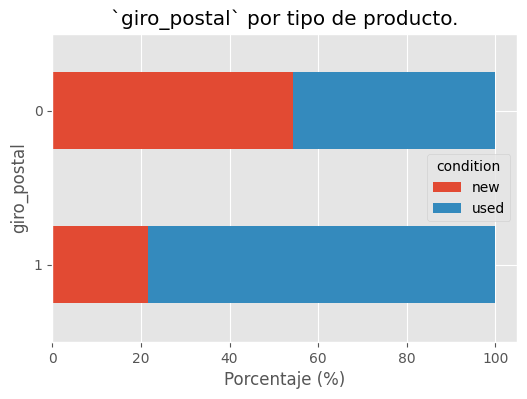

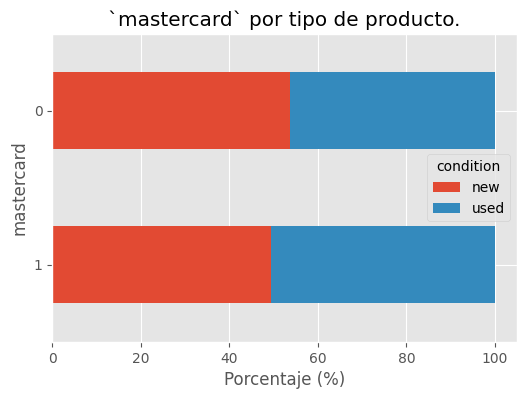

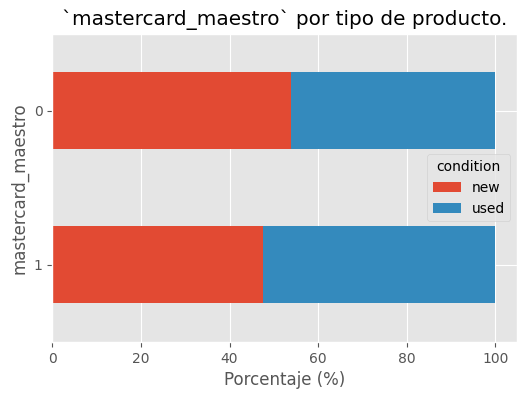

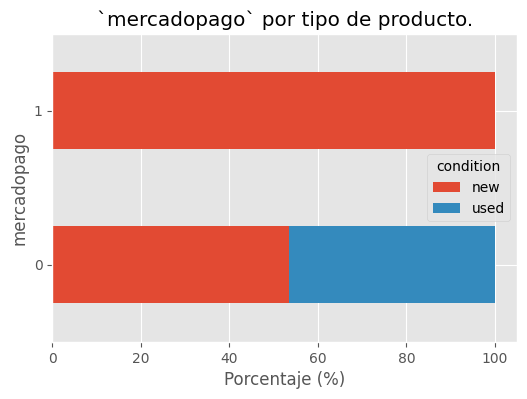

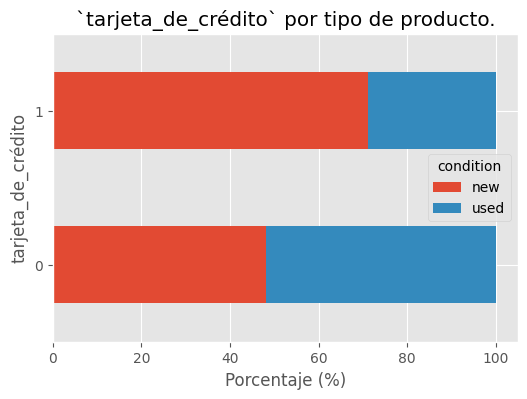

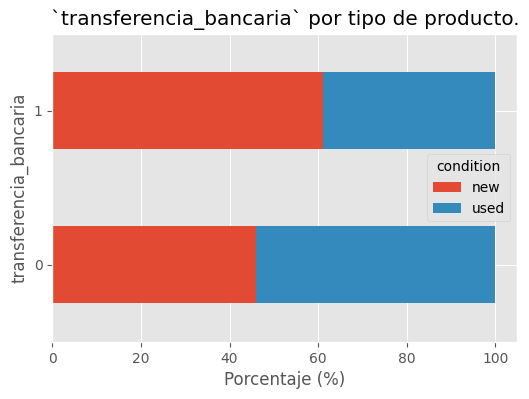

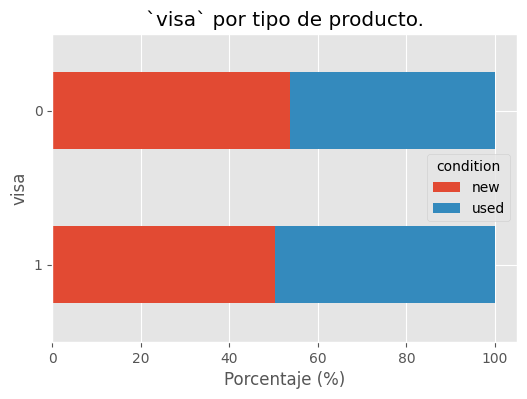

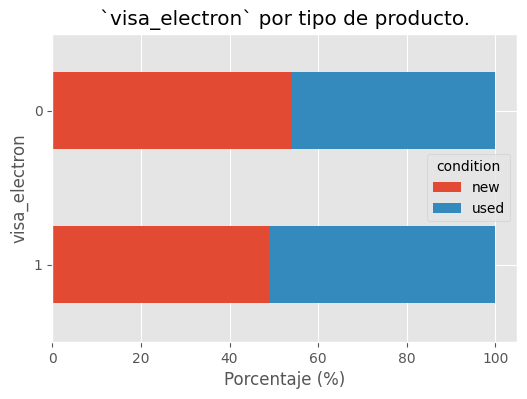

In [128]:
for col in [c for c in df.columns if c.startswith("non_mercado_pago_payment_method")]:
    df.groupby(by=col, observed=True, dropna=False)["condition"] \
        .value_counts(normalize=True, dropna=False) \
        .mul(100) \
        .round(2) \
        .unstack() \
        .sort_values("new") \
        .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)",
              title=f"`{col.replace('non_mercado_pago_payment_methods__', '')}` por tipo de producto.",
              ylabel=col.replace('non_mercado_pago_payment_methods__', ''),
              figsize=(6, 4))
    plt.show()

- Solo cheque y giro postal parecen tener proporciones sesgadas hacia una clase.

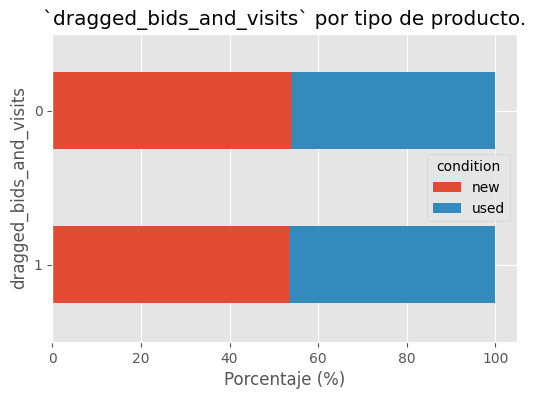

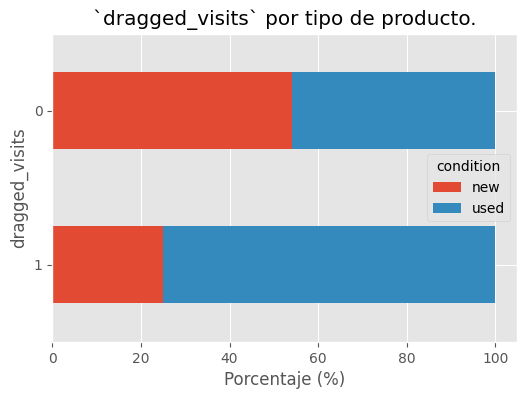

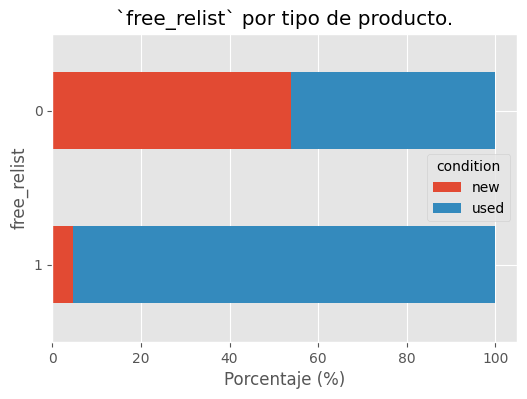

In [129]:
for col in [c for c in df.columns if c.startswith("tags")]:
    df.groupby(by=col, observed=True, dropna=False)["condition"] \
        .value_counts(normalize=True, dropna=False) \
        .mul(100) \
        .round(2) \
        .unstack() \
        .sort_values("new") \
        .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)",
              title=f"`{col.replace('tags__', '')}` por tipo de producto.",
              ylabel=col.replace('tags__', ''),
              figsize=(6, 4))
    plt.show()

In [131]:
df.groupby(by="shipping__tags", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`shipping__tags` por tipo de producto.", figsize=(6, 4))
plt.show()

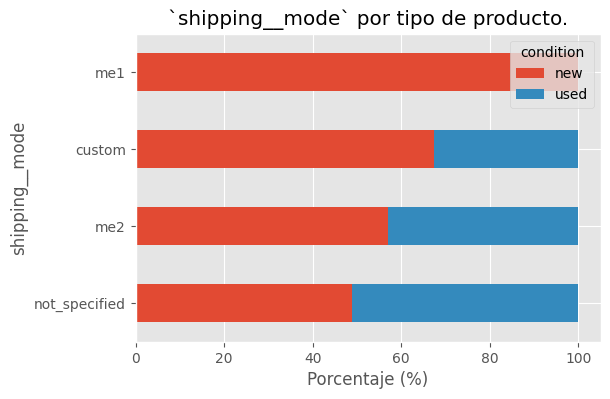

In [132]:
df.groupby(by="shipping__mode", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`shipping__mode` por tipo de producto.", figsize=(6, 4))
plt.show()

- Tipo de shipping me1 siempre a productos nuevos.
    - Mercado Envíos 1 (ME1): es una modalidad de envío que permite a los vendedores vender a través de Mercado Libre, utilizando su propia logística o servicios de terceros.
    - Mercado Envíos 2 (ME2): es la modalidad de envío de Mercado Libre, donde se gestiona toda la logística utilizando diversos medios como correos, agencias, entre otros.

https://developers.mercadolibre.com.ar/es_ar/mercado-envios

#### Strings

In [ ]:

df.groupby(by="shipping__mode", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_values("new") \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`shipping__mode` por tipo de producto.", figsize=(6, 4))
plt.show()

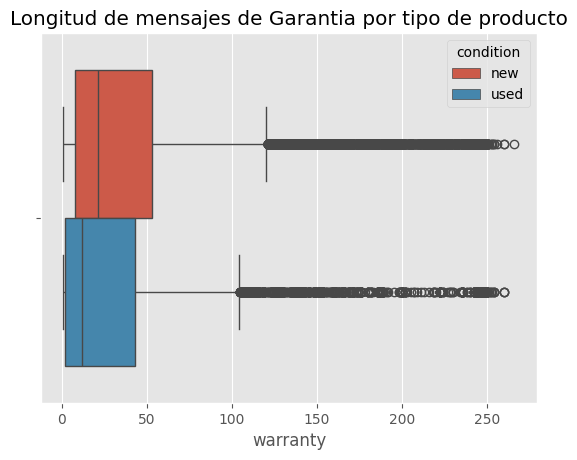

In [137]:
sns.boxplot(data=df, x=df["warranty"].str.len(), hue="condition")
plt.title("Longitud de mensajes de Garantia por tipo de producto")
plt.show()

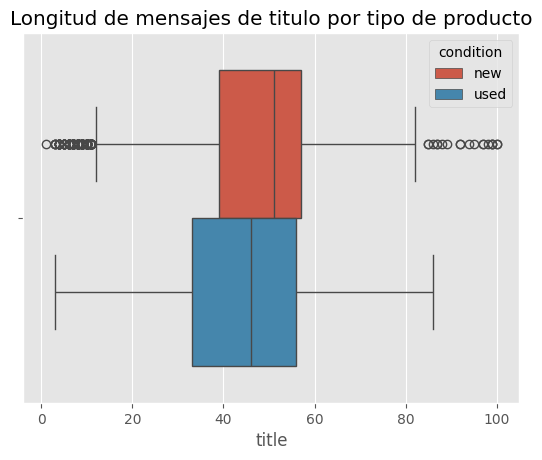

In [138]:
sns.boxplot(data=df, x=df["title"].str.len(), hue="condition")
plt.title("Longitud de mensajes de titulo por tipo de producto")
plt.show()

- Los productos nuevos tienen mensajes ligeramente mas largos de Garantia y Titulo que los de productos usados. 

#### Fechas

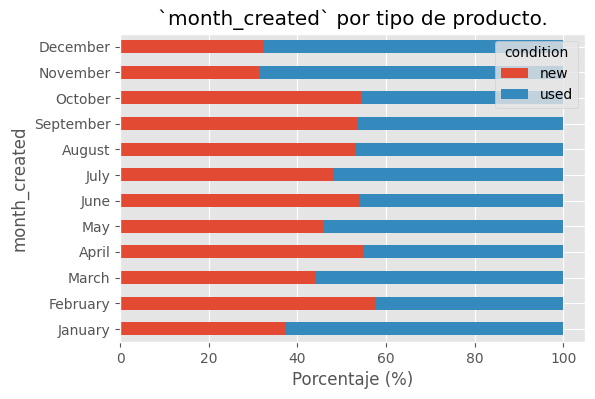

In [162]:
df.assign(month_created=df["date_created"].dt.month).groupby(by="month_created", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_index() \
    .rename(dict(zip(df["date_created"].dt.month, df["date_created"].dt.month_name()))) \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`month_created` por tipo de producto.", figsize=(6, 4))
plt.show()

- En Noviembre y Diciembre se suelen postear mas productos usados.

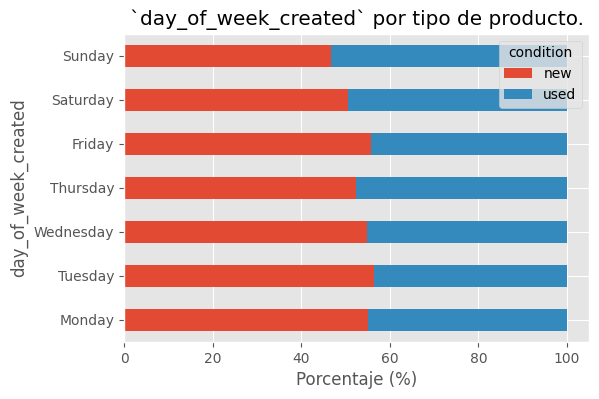

In [165]:
df.assign(day_of_week_created=df["date_created"].dt.day_of_week).groupby(by="day_of_week_created", observed=True, dropna=False)["condition"] \
    .value_counts(normalize=True, dropna=False) \
    .mul(100) \
    .round(2) \
    .unstack() \
    .sort_index() \
    .rename(dict(zip(df["date_created"].dt.day_of_week, df["date_created"].dt.day_name()))) \
    .plot(kind="barh", stacked=True, xlabel="Porcentaje (%)", title="`day_of_week_created` por tipo de producto.", figsize=(6, 4))
plt.show()